In [ ]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

In [2]:
import numpy as np
import os 
import pickle
from matplotlib import pyplot as plt
import pandas as pd

from importlib import reload
import helper_funcs; reload(helper_funcs);from helper_funcs import *
import make_models; reload(make_models);from make_models import *

In [3]:
## MAKE THE EMBEDDINGS

In [4]:
# LOAD ABIDE DATA
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

# LOAD SFARI 
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

In [5]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading


In [6]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)

fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'
loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

In [7]:
v = (sfari_subs_del+sfari_subs_dupl) # 16p SUBJECTS
a = df['DxGroup'].values==1 # ASD subjects
w = 2

In [8]:
embedding_vae = encoder.predict(ABIDE_data[a,:,:,:])[w]
embedding_bg = z_encoder.predict(ABIDE_data[a,:,:,:])[w]
embedding_sl = s_encoder.predict(ABIDE_data[a,:,:,:])[w]

sfari_embedding_vae = encoder.predict(SFARI_data[v,:,:,:])[w]
sfari_embedding_bg = z_encoder.predict(SFARI_data[v,:,:,:])[w]
sfari_embedding_sl = s_encoder.predict(SFARI_data[v,:,:,:])[w]

In [9]:
reducer_bg_abide = umap.UMAP().fit(embedding_bg)
reducer_sl_abide = umap.UMAP().fit(embedding_sl)
reducer_vae_abide = umap.UMAP().fit(embedding_vae)

reducer_bg_sfari = umap.UMAP().fit(sfari_embedding_bg)
reducer_sl_sfari = umap.UMAP().fit(sfari_embedding_sl)
reducer_vae_sfari = umap.UMAP().fit(sfari_embedding_vae)

In [10]:
%%capture 
bg_space_abide = reducer_bg_abide.transform(embedding_bg);
bg_space_sfari = reducer_bg_abide.transform(sfari_embedding_bg);

sl_space_abide = reducer_sl_abide.transform(embedding_sl);
sl_space_sfari = reducer_sl_abide.transform(sfari_embedding_sl);

vae_space_abide = reducer_vae_abide.transform(embedding_vae);
vae_space_sfari = reducer_vae_abide.transform(sfari_embedding_vae);

In [11]:
bg_Sspace_sfari = reducer_bg_sfari.transform(sfari_embedding_bg);
sl_Sspace_sfari = reducer_sl_sfari.transform(sfari_embedding_sl);
vae_Sspace_sfari = reducer_vae_sfari.transform(sfari_embedding_vae);

In [19]:
# SAVE EMBEDDING
ofdir = '/mmfs1/data/aglinska/BC-MRI-AE/Data/'

save = False
if save: 
    
    embedded_data = {
    'embedding_bg':embedding_bg,
    'embedding_sl':embedding_sl,
    'embedding_vae':embedding_vae,
                     
    'sfari_embedding_vae':sfari_embedding_vae,
    'sfari_embedding_bg':sfari_embedding_bg,
    'sfari_embedding_sl':sfari_embedding_sl,
        
    'bg_space_abide':bg_space_abide,
    'sl_space_abide':sl_space_abide,
    'vae_space_abide': vae_space_abide,
        
    'bg_space_sfari':bg_space_sfari,        
    'sl_space_sfari':sl_space_sfari,
    'vae_space_sfari':vae_space_sfari,

    'bg_Sspace_sfari':bg_Sspace_sfari,
    'sl_Sspace_sfari':sl_Sspace_sfari,
    'vae_Sspace_sfari':vae_Sspace_sfari,
        
    'reducer_bg_abide':reducer_bg_abide,
    'reducer_sl_abide':reducer_sl_abide,
    'reducer_vae_abide':reducer_vae_abide,
        
    'reducer_bg_sfari':reducer_bg_sfari,
    'reducer_sl_sfari':reducer_sl_sfari,
    'reducer_vae_sfari':reducer_vae_sfari,}

    pickle.dump(embedded_data,open(os.path.join(ofdir,'embedded_data.pickle'),'wb'))

In [13]:
# LOAD AND SHOW EMBEDDINGS

In [14]:
embedded_data = pickle.load(open(os.path.join(ofdir,'embedded_data.pickle'),'rb'))

In [15]:
list(embedded_data.keys())

['embedding_bg',
 'embedding_sl',
 'embedding_vae',
 'sfari_embedding_vae',
 'sfari_embedding_bg',
 'sfari_embedding_sl',
 'bg_space_abide',
 'sl_space_abide',
 'vae_space_abide',
 'bg_space_sfari',
 'sl_space_sfari',
 'vae_space_sfari',
 'bg_Sspace_sfari',
 'sl_Sspace_sfari',
 'vae_Sspace_sfari',
 'reducer_bg_abide',
 'reducer_sl_abide',
 'reducer_vae_abide',
 'reducer_bg_sfari',
 'reducer_sl_sfari',
 'reducer_vae_sfari']

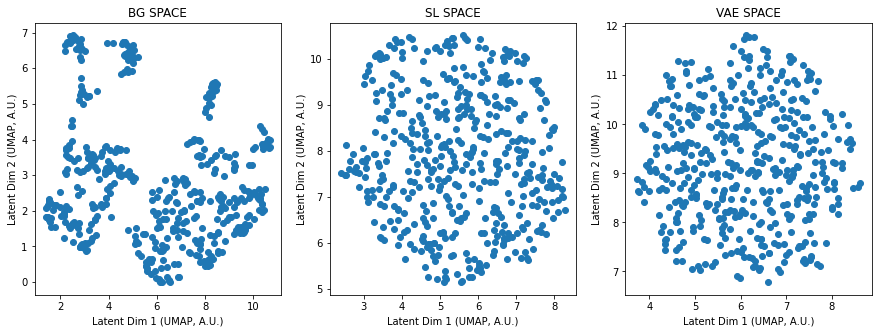

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(embedded_data['bg_space_abide'][:,0],embedded_data['bg_space_abide'][:,1])
#plt.scatter(bg_space_sfari[:,0],bg_space_sfari[:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('BG SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,2)
plt.scatter(embedded_data['sl_space_abide'][:,0],embedded_data['sl_space_abide'][:,1])
#plt.scatter(sl_space_sfari[:,0],sl_space_sfari[:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('SL SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,3)
plt.scatter(embedded_data['vae_space_abide'][:,0],embedded_data['vae_space_abide'][:,1])
#plt.scatter(vae_space_sfari[:,0],vae_space_sfari[:,1])
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')
#plt.legend(['ABIDE','SFARI']);
plt.title('VAE SPACE')
plt.savefig('/mmfs1/data/aglinska/figures/spaces_abide.png',dpi=300)

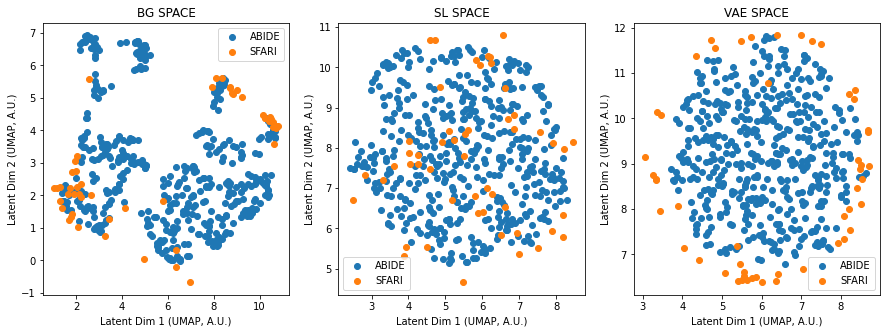

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(embedded_data['bg_space_abide'][:,0],embedded_data['bg_space_abide'][:,1])
plt.scatter(embedded_data['bg_space_sfari'][:,0],embedded_data['bg_space_sfari'][:,1])
#plt.scatter(bg_space_sfari[:,0],bg_space_sfari[:,1])
plt.legend(['ABIDE','SFARI']);
plt.title('BG SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,2)
plt.scatter(embedded_data['sl_space_abide'][:,0],embedded_data['sl_space_abide'][:,1])
plt.scatter(embedded_data['sl_space_sfari'][:,0],embedded_data['sl_space_sfari'][:,1])
#plt.scatter(sl_space_sfari[:,0],sl_space_sfari[:,1])
plt.legend(['ABIDE','SFARI']);
plt.title('SL SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,3)
plt.scatter(embedded_data['vae_space_abide'][:,0],embedded_data['vae_space_abide'][:,1])
plt.scatter(embedded_data['vae_space_sfari'][:,0],embedded_data['vae_space_sfari'][:,1])
#plt.scatter(vae_space_sfari[:,0],vae_space_sfari[:,1])
plt.legend(['ABIDE','SFARI']);
plt.title('VAE SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')
plt.savefig('/mmfs1/data/aglinska/figures/spaces_abide_sfari.png',dpi=300)

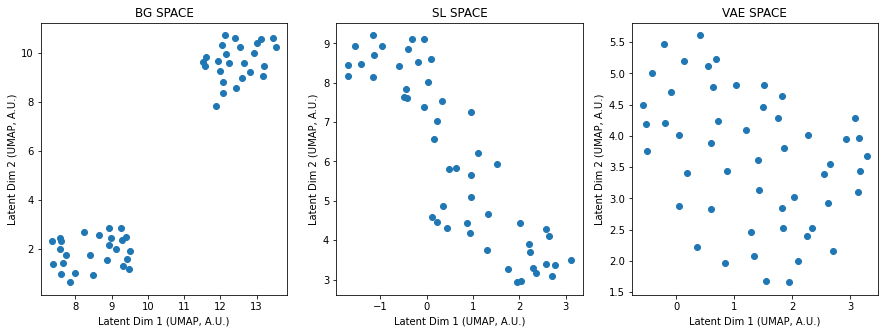

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
#plt.scatter(bg_space_abide[:,0],bg_space_abide[:,1])
plt.scatter(embedded_data['bg_Sspace_sfari'][:,0],embedded_data['bg_Sspace_sfari'][:,1])
plt.title('BG SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,2)
#plt.scatter(sl_space_abide[:,0],sl_space_abide[:,1])
plt.scatter(embedded_data['sl_Sspace_sfari'][:,0],embedded_data['sl_Sspace_sfari'][:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('SL SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,3)
#plt.scatter(vae_space_abide[:,0],vae_space_abide[:,1])
plt.scatter(embedded_data['vae_Sspace_sfari'][:,0],embedded_data['vae_Sspace_sfari'][:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('VAE SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')
plt.savefig('/mmfs1/data/aglinska/figures/spaces_sfari.png',dpi=300)